# Information Retrieval - Corpus Filtering  
This notebook retrieves abstracts relevant to pandemics and then uses topic modeling to analyze the chosen abstracts.  Two info retrieval techniques are used: Literal Term Matching and Latent Semantic Indexing.  These are linear algebra techniques.  
We use the Scikit-Learn library.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# pull in data
df = pd.read_pickle("../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.reset_index(inplace = True, drop = True)

In [3]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [4]:
df.shape

(1143869, 30)

In [5]:
docs = df["final_tokens"]  

### Term Matching

In [6]:
# new approach to grab all "pandemic" matches

term_match_idx = []

for i, abstract in enumerate(docs):
    if ('pandemic' in abstract): 
        term_match_idx.append(i)
        

In [7]:
len(term_match_idx) 

5783

#### Word cloud

In [8]:
# Find doc-term matrix

vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(docs)

terms = vectorizer.get_feature_names()

In [9]:
dtm.shape

(1143869, 1629626)

In [10]:
count = 0

for term in terms:
    if 'pandemic' in term:
        print(term)
        count = count + 1
        
print(count)

1918_influenza_pandemic
1918_pandemic
1957_1968_pandemic
2009_pandemic_h1n1
aidspandemic
andpandemic
anotherpandemic
apandemic
assesspandemic
betweenpandemic
bothpandemic
causedpandemic
chikvpandemic
cov_2pandemic
covid19_pandemic
covid19pandemic
covid_19_pandemic
covid_19pandemic
covid_19pandemic5
covid_pandemic
covidpandemic
criticalpandemic
currentpandemic
detetermrminineififththesuprragenomeofftthepandemiciccllonesiis
devastatingpandemic
ebolapandemic
emergingpandemic
escalatingpandemic
establishingpandemic
forpandemic
frompandemic
futurepandemic
globalpandemic
greatpandemic2
growingpandemic
h1n1_pandemic
h1n1pandemic
hivpandemic
howpandemic
humanpandemic
increasedpandemic
influenzapandemic
inpandemic
interpandemic
interpandemic_pandemic
majorpandemic
multiclade_recombinant_pandemic
newpandemic
non_pandemic
occasional_pandemic
occasionalpandemic
ofpandemic
ofseasonal_pandemic
ongoingpandemic
pandemic
pandemic1
pandemic2
pandemic2009
pandemic57499
pandemic_1918
pandemic_1918_1919
pa

In [11]:
term_counts = dtm.sum(axis=0)

In [12]:
d = {}

for i, term in enumerate(terms):
    if 'pandemic' in term:
        #print(term)
        d[term] = term_counts[0,i]

In [13]:
d

{'1918_influenza_pandemic': 61,
 '1918_pandemic': 96,
 '1957_1968_pandemic': 19,
 '2009_pandemic_h1n1': 64,
 'aidspandemic': 4,
 'andpandemic': 7,
 'anotherpandemic': 1,
 'apandemic': 13,
 'assesspandemic': 1,
 'betweenpandemic': 1,
 'bothpandemic': 2,
 'causedpandemic': 3,
 'chikvpandemic': 1,
 'cov_2pandemic': 2,
 'covid19_pandemic': 28,
 'covid19pandemic': 4,
 'covid_19_pandemic': 1293,
 'covid_19pandemic': 26,
 'covid_19pandemic5': 1,
 'covid_pandemic': 23,
 'covidpandemic': 2,
 'criticalpandemic': 2,
 'currentpandemic': 5,
 'detetermrminineififththesuprragenomeofftthepandemiciccllonesiis': 1,
 'devastatingpandemic': 1,
 'ebolapandemic': 2,
 'emergingpandemic': 1,
 'escalatingpandemic': 2,
 'establishingpandemic': 1,
 'forpandemic': 1,
 'frompandemic': 1,
 'futurepandemic': 4,
 'globalpandemic': 3,
 'greatpandemic2': 1,
 'growingpandemic': 4,
 'h1n1_pandemic': 67,
 'h1n1pandemic': 6,
 'hivpandemic': 14,
 'howpandemic': 1,
 'humanpandemic': 2,
 'increasedpandemic': 2,
 'influenzapan

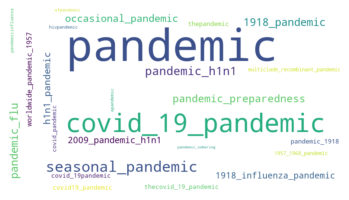

In [14]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=900, height= 500, scale=1, max_words = 25, background_color='white').generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig("pan_wc.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("pan_wc.pdf", dpi = 800, bbox_inches = "tight")
plt.show()

## Latent Semantic Indexing (LSI)

### Helper Functions

In [15]:
# Create binary query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [16]:
def return_top_abstracts(scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if top_n = -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        #n = sum(scores > 0)
        ix = scores_sorted_idx #[:n]
    else:
        ix = scores_sorted_idx[:top_n]
    
    #print(ix[0:10])
    
    return ix
    

In [17]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

In [18]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(docs)

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [19]:
# CHANGE QUERY WORDS HERE

query_words = []

for word in tf_idf_terms:
    if 'pandemic' in word:
        query_words.append(word)

#query_words = ['pandemic', 'pandemics'] 
              
q = create_query(query_words, tf_idf_terms)

In [20]:
query_words

['1918_influenza_pandemic',
 '1918_pandemic',
 '1957_1968_pandemic',
 '2009_pandemic_h1n1',
 'aidspandemic',
 'andpandemic',
 'anotherpandemic',
 'apandemic',
 'assesspandemic',
 'betweenpandemic',
 'bothpandemic',
 'causedpandemic',
 'chikvpandemic',
 'cov_2pandemic',
 'covid19_pandemic',
 'covid19pandemic',
 'covid_19_pandemic',
 'covid_19pandemic',
 'covid_19pandemic5',
 'covid_pandemic',
 'covidpandemic',
 'criticalpandemic',
 'currentpandemic',
 'detetermrminineififththesuprragenomeofftthepandemiciccllonesiis',
 'devastatingpandemic',
 'ebolapandemic',
 'emergingpandemic',
 'escalatingpandemic',
 'establishingpandemic',
 'forpandemic',
 'frompandemic',
 'futurepandemic',
 'globalpandemic',
 'greatpandemic2',
 'growingpandemic',
 'h1n1_pandemic',
 'h1n1pandemic',
 'hivpandemic',
 'howpandemic',
 'humanpandemic',
 'increasedpandemic',
 'influenzapandemic',
 'inpandemic',
 'interpandemic',
 'interpandemic_pandemic',
 'majorpandemic',
 'multiclade_recombinant_pandemic',
 'newpandemic'

In [21]:
len(query_words)

115

In [22]:
# Find the Truncated SVD of the TF-IDF matrix

lsa = TruncatedSVD(n_components=50, random_state=1)  # CHANGE THE NUMBER OF COMPONENTS - NOTE: MORE COMPONENTS 
                                                      # GIVES YOU A MORE ACCURATE APPROXIMATION OF THE DOC-TERM 
                                                      # MATRIX, BUT IS ALSO MORE EXPENSIVE AND MAY NOT LEAD TO THE 
                                                      # BEST INFO RETRIEVAL RESULTS.
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [23]:
S = lsa.singular_values_

In [24]:
S

array([162.75474643,  99.18171844,  72.81242855,  68.68440984,
        66.50219492,  62.6294814 ,  58.56022561,  54.69338407,
        51.52434424,  50.36840028,  48.64617919,  47.53183664,
        45.69105895,  43.9589213 ,  43.67628345,  43.4223868 ,
        41.37011445,  40.76775442,  40.00801983,  39.73592333,
        39.01442429,  38.77479471,  38.24795062,  37.19103778,
        36.98271593,  36.4097371 ,  36.32088637,  35.87097828,
        35.66275333,  35.04155178,  34.90376575,  34.67921138,
        34.52276579,  34.39432847,  34.0049888 ,  33.23316325,
        33.17674194,  32.83536346,  32.66038544,  32.61196385,
        32.37058852,  32.01287748,  31.93379447,  31.76628275,
        31.59189268,  31.34461234,  30.88534793,  30.62092066,
        30.39109506,  30.3073787 ])

In [25]:
# transform query to be in same space as documents

q = q.reshape(1,-1)  # changes (n,) vector to (1,n)
qhat = lsa.transform(q)

In [26]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 50)
(1143869, 50)
(50, 1629626)


In [27]:
lsa_scores = cosine_similarity(qhat, USigma)  

In [28]:
sum(lsa_scores[0] > 0)

# 50: 662812

662812

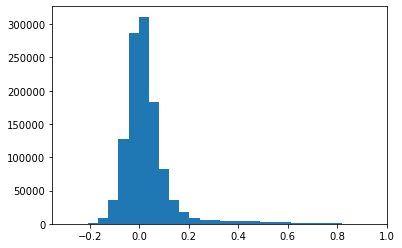

In [29]:
plt.hist(lsa_scores[0], bins = 30);
#plt.xlim(0.9, 1.1)

In [30]:
#np.percentile(lsa_scores[0], 93)

sum(lsa_scores[0] >= 0.70)#/len(lsa_scores[0])

# 50: 13556 
# 70: 2635
# 75: 1432

2635

In [31]:
np.percentile(lsa_scores[0], 99.77)

0.700051730783248

In [32]:
100*2635/len(lsa_scores[0])

0.2303585463020678

In [33]:
lsa_idx = return_top_abstracts(lsa_scores[0], -1)  # CHANGE NUMBER OF TOP DOCS RETURNED 
top_lsa_abstracts = docs[lsa_idx]

# top scores
lsa_scores[0][lsa_idx][0:10]

array([0.94010028, 0.93318869, 0.93318869, 0.93318869, 0.93318869,
       0.93318869, 0.93178611, 0.93178611, 0.92631246, 0.92631246])

In [34]:
top_lsa_abstracts[2625:2650]

1010234    objective identify host viral genetic determin...
116545     influenza virus niaid class priority pathogen ...
18918      influenza virus niaid class priority pathogen ...
1083940    project overarching goal prometheus consortium...
986455     project overarching goal prometheus consortium...
276292     providedviruse antiviral vaccine enter body sk...
62364      providedviruse antiviral vaccine enter body sk...
171836     providedviruse antiviral vaccine enter body sk...
441132     providedviruse antiviral vaccine enter body sk...
366014     providedviruse antiviral vaccine enter body sk...
813360     recently study attempt identify viral pathogen...
915586     recently study attempt identify viral pathogen...
1021163    recently study attempt identify viral pathogen...
760676     recently study attempt identify viral pathogen...
93498      dengue serotype vaccine development live atten...
313560     influenza virus negative sense single strand r...
231680     influenza vir

In [35]:
top_lsa_abstracts.iloc[2635]

'recently study attempt identify viral pathogen restrict testing previously know virus detectable cell culture pcr stain antigen specific antibody sero_conversion testing restrict characterize virus largely discover cytopathic effect cell grow vitro introduction high throughput dna sequence allow metagenomic approach identify virus present reveal large number previously unknown virus belong different viral family particularly fece human wild domesticate animal high sensitivity nucleic_acid_testing reveal high rate enteric viral infection diarrheic healthy human animal metagenomic bioinformatic approach generate comprehensive list enteric virus present large cohort rhesus_macaque idiopathic chronic diarrhea icd common inflammatory condition colon resemble human ulcerative_colitis order identify candidate viral pathogen associate unexplained disease classic case control study compare presence viral concentration virus present large number animal icd healthy control viral replication viru

In [36]:
lsa_scores[0][lsa_idx][2625:2640]

array([0.70014147, 0.70011195, 0.70011195, 0.70006402, 0.70006402,
       0.70005173, 0.70005173, 0.70005173, 0.70005173, 0.70005173,
       0.69998791, 0.69998791, 0.69998791, 0.69998791, 0.69997282])

### How do LSI and Term Matching Overlap?

In [37]:
# look at the intersection/difference -- LSI seems to pick up mainly influenza

temp1 = list(set(term_match_idx).intersection(set(lsa_idx[0:2635])))
print(len(temp1))
temp2 = list(set(term_match_idx) - set(lsa_idx[0:2635]))
print(len(temp2))

847
4936


In [38]:
df['ABSTRACT'].iloc[temp2[2110]]

'DESCRIPTION (provided by applicant): Current influenza vaccines are targeted to induce immune responses to the variable antigens hemagglutinin and neuraminidase, which are effective for strain-specific protection. However, such vaccination does not provide protection against the emergence of antigenically distinct strains as shown by the failure to control the 2009 H1N1 pandemic at the early stage of its outbreak. The goal of our proposed project is to develop novel influenza vaccines that will induce broadly cross protective immunity against antigenically drifted strains in the absence of adjuvants. To achieve this goal, novel approaches will be proposed to develop a highly conserved antigenic target in an immunogenic form and to incorporate this into the influenza vaccination. A promising candidate as a conserved antigenic target is the membrane protein M2 containing a highly conserved extracellular domain. M2 on virus-like particles (VLPs) in a membrane-anchored form (M2 VLPs) will

In [39]:
len(lsa_idx)

1143869

In [40]:
# find term matching indices in sorted lsa scores list

mask = np.isin(lsa_idx, term_match_idx)
tm_in_lsa_idx = np.nonzero(mask)  # returns tuple of length 1 (mask is 1d)
tm_lsa_score = lsa_scores[0][lsa_idx[tm_in_lsa_idx]]        

In [41]:
pd.Series(tm_lsa_score).describe()

count    5783.000000
mean        0.346336
std         0.276067
min        -0.104371
25%         0.099012
50%         0.295506
75%         0.584152
max         0.931786
dtype: float64

In [42]:
# tm_in_lsa_idx marks the index in lsa_idx where the term matching elemetns live.  
# lsa_idx is sorted (largest to smallest scores)!

pd.Series(tm_in_lsa_idx[0]).describe()

count    5.783000e+03
mean     1.467787e+05
std      2.456746e+05
min      6.000000e+00
25%      7.461500e+03
50%      3.648300e+04
75%      1.405345e+05
max      1.121347e+06
dtype: float64

In [43]:
p = np.percentile(tm_in_lsa_idx[0],75)
print(p)

140534.5


In [44]:
# lsa_idx has length of df.  

100*p/len(df)

12.285891129141536

In [45]:
100*140534/len(df)

12.285847417842428

## Create filtered corpus

We use the results of our two information retrieval techniques to create a new, smaller corpus that only contains abstracts relevant to the query. 

In [46]:
docs_ix = np.concatenate([term_match_idx, lsa_idx[0:2635]]) 

In [47]:
docs_idx = np.unique(docs_ix)

In [48]:
docs_idx.shape

(7571,)

**create case-study corpuses**

In [49]:
filt_corpus = df.loc[docs_idx, :]  # could have also used iloc since we reset the dataframe index after ingestion

In [50]:
filt_corpus.shape

(7571, 30)

In [51]:
filt_corpus.to_pickle("./pandemic_corpus.pkl")

#pandemic_corpus = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#pandemic_corpus.shape

In [52]:
text = filt_corpus["final_tokens"]

## Topic Modeling with relevant pandemic abstracts

In [53]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [54]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'aim', 'project']

nmf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
nmf_tf_idf = nmf_vectorizer.fit_transform(text)

In [55]:
nmf_tf_idf.shape

(7571, 21980)

In [56]:
# topic modeling with NMF

nmf_model = NMF(n_components=20, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [57]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('virus', 4.04441031469278)
('human', 0.8023040523954229)
('infection', 0.3831224526774793)
('genetic', 0.379698728266028)
('transmission', 0.37392711977297866)
('host', 0.3697507268810123)
('mutation', 0.36097474845893873)
('cause', 0.354653999939141)
('viral', 0.32490639102799757)
('infect', 0.307015604300378)

Topic 1:
('social', 0.8722390300839232)
('covid_19', 0.818275128149165)
('health', 0.8122035759498376)
('datum', 0.8013395873870156)
('community', 0.6649153932979067)
('behavior', 0.5678267535618879)
('intervention', 0.554357959652187)
('risk', 0.5379564268989002)
('public', 0.520162787476839)
('model', 0.5055835414712945)

Topic 2:
('influenza', 3.377917399266601)
('vaccination', 0.40731015682093735)
('strain', 0.34196837094561916)
('effectiveness', 0.3032906103607889)
('virus', 0.29148200942229363)
('year', 0.28116134075200766)
('age', 0.26209785339448977)
('child', 0.25562363826095713)
('infection', 0.22199553259593494)
('respiratory', 0.22054639934400863)

Topic 

In [58]:
docs_ix = term_match_idx 
docs_idx = np.unique(docs_ix)
docs_idx.shape

(5783,)

In [59]:
# topic model with just term matching

filt_corpus2 = df.loc[docs_idx, :]
print(filt_corpus2.shape)

text = filt_corpus2["final_tokens"]
print(len(text))

(5783, 30)
5783


In [60]:
filt_corpus2.to_pickle("./term-match-pan-corpus.pkl")

In [61]:
# Create a TF-IDF document-term matrix for the pandemics corpus 

# TRY DIFFERENT PARAMETERS IN THE TF-IDF DOC-TERM MATRIX SET-UP

stop_wds = ['research', 'aim', 'project']
nmf_vectorizer2 = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds) 
nmf_tf_idf2 = nmf_vectorizer2.fit_transform(text)
print(nmf_tf_idf2.shape)

(5783, 18703)


In [62]:
# topic modeling with NMF

nmf_model2 = NMF(n_components=20, random_state=1)  # TRY DIFFERENT NUMBERS OF TOPICS
W = nmf_model2.fit_transform(nmf_tf_idf2)
H = nmf_model2.components_

In [63]:
print_topics(nmf_model2, nmf_vectorizer2, 10)


Topic 0:
('virus', 2.3433546835060874)
('host', 1.3099661492895747)
('human', 1.2052427856437364)
('viral', 0.8344924344739811)
('gene', 0.7082435168387488)
('evolution', 0.6362455104239401)
('genetic', 0.6024134293883733)
('sequence', 0.584006557464395)
('pathogen', 0.5485592461829775)
('model', 0.4729022050521842)

Topic 1:
('social', 0.8579437981516133)
('health', 0.8409930486151155)
('covid_19', 0.7603569151092018)
('datum', 0.6944667093916935)
('community', 0.5946572716040567)
('behavior', 0.5784645886494667)
('intervention', 0.5607518312192181)
('public', 0.5510615086353723)
('model', 0.5432727714811741)
('risk', 0.5304616192967595)

Topic 2:
('hiv', 2.9231039340339042)
('aids', 0.48762124511457877)
('prevention', 0.2751340273999703)
('trial', 0.2737458614896464)
('intervention', 0.2084084719271732)
('infection', 0.19836670449393565)
('infect', 0.19737950607989374)
('clinical', 0.17915435647258926)
('antiretroviral', 0.1754654752181592)
('woman', 0.16836823946854815)

Topic 3:
(